## Importing necessary libraries

In [38]:
#!pip install pmdarima

In [1]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Uploading the dataset

In [3]:
df = pd.read_csv(r"../data/model_ready_data.csv", parse_dates=['date'])

## Splitting data into train and test sets (80-20 split)

In [5]:
train_size = int(len(df) * 0.8)
train, test = df['price_diff'].iloc[:train_size], df['price_diff'].iloc[train_size:]

## Fitting ARIMA model
As already concluded in EDA part, we start with (0,1,0) as baseline - we'll optimize later

In [7]:
arima_model = ARIMA(train, order=(0,1,0))
arima_fit = arima_model.fit()

## Displaying model summary

In [9]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             price_diff   No. Observations:                 1168
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -323.561
Date:                Wed, 13 Aug 2025   AIC                            649.122
Time:                        01:09:25   BIC                            654.184
Sample:                             0   HQIC                           651.031
                               - 1168                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1006      0.001     78.412      0.000       0.098       0.103
Ljung-Box (L1) (Q):                 393.41   Jarque-Bera (JB):             18037.14
Prob(Q):                              0.00   Pr

## Making predictions

In [11]:
arima_forecast = arima_fit.forecast(steps=len(test))

## Evaluation metrics

In [13]:
arima_mse = mean_squared_error(test, arima_forecast)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(test, arima_forecast)

print(f"\nARIMA Model Performance:")
print(f"MSE: {arima_mse:.4f}")
print(f"RMSE: {arima_rmse:.4f}")
print(f"MAE: {arima_mae:.4f}")


ARIMA Model Performance:
MSE: 0.0185
RMSE: 0.1360
MAE: 0.0881


These performance metrics indicate that our ARIMA(0,1,0) model has a very low average forecast error in the training dataset, which is a good sign for its predictive capability

## Plotting results

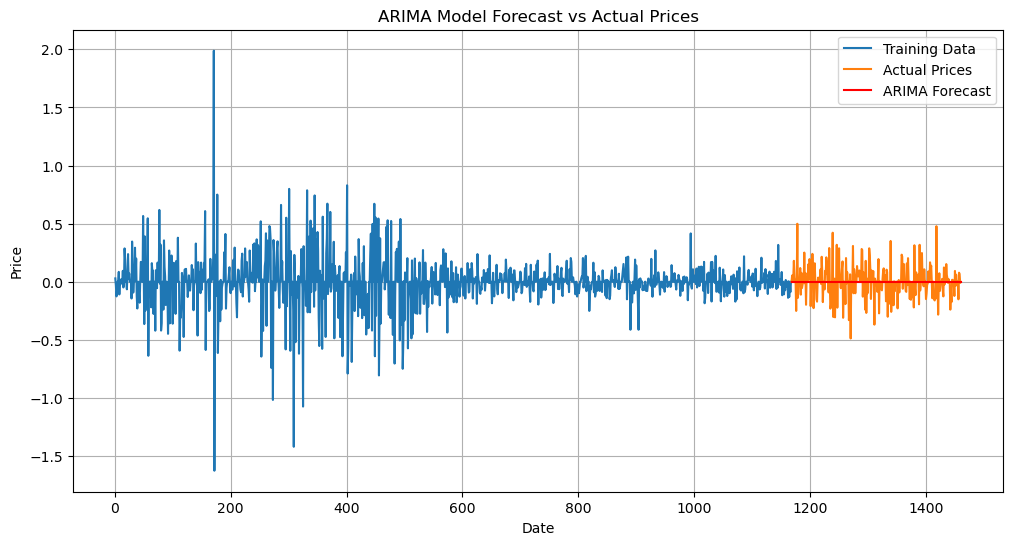

In [15]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Prices')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Model Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Interpretation
As the series behaves like a random walk, the flat-line forecast is the most accurate one. 

A random walk model assumes that the best prediction for the next value is simply the last observed value, with a random error component. When we forecast multiple steps into the future with a random walk, the "best guess" remains the last known value, as there's no trend or seasonality to project forward

The flat forecast suggests that while our original price series had a clear trend (non-stationarity), its day-to-day movements are essentially unpredictable.

## SARIMA

In order not to specify the model manually we use auto_arima to find best parametrs. It selects the best model based on the Akaike Information Criterion (AIC). The model with the lowest AIC is considered the best fit because it provides the best balance between model complexity and goodness of fit

In [17]:
train = train.dropna()
# Fit the auto_arima model
auto_model = pm.auto_arima(train,
                           start_p=0, start_q=0,
                           max_p=3, max_q=3,
                           m=12,  # Monthly seasonality
                           start_P=0, start_Q=0,
                           max_P=2, max_Q=2,
                           d=1, D=1,
                           seasonal=True,
                           trace=True,  # Print results of each step
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1382.187, Time=0.41 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=586.617, Time=0.64 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.83 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=924.945, Time=0.18 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=456.962, Time=1.82 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=11.74 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=7.01 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=927.303, Time=0.77 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=304.249, Time=1.71 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=428.502, Time=0.96 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=13.00 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=8.05 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=228.258, Time=2.55 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=350.181, Time=1.12 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Ti

The best parameters are now stored in auto_model.order and auto_model.seasonal_order

In [19]:
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

print(f"Best Non-Seasonal Order: {best_order}")
print(f"Best Seasonal Order: {best_seasonal_order}")

Best Non-Seasonal Order: (3, 1, 0)
Best Seasonal Order: (2, 1, 0, 12)


## Fit SARIMA model with seasonal components
Now we can use our stored best parametrs for our model's seasonal or non-seaosanal order. Then we can print results

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

sarima_model = SARIMAX(train,
                      order=best_order,
                      seasonal_order=best_seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)

sarima_fit = sarima_model.fit(disp=False)

print(sarima_fit.summary())

C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         price_diff   No. Observations:                 1167
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -111.953
Date:                            Wed, 13 Aug 2025   AIC                            235.905
Time:                                    01:15:25   BIC                            266.069
Sample:                                         0   HQIC                           247.303
                                           - 1167                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8768      0.015    -59.193      0.000      -0.906      -0.848
ar.L2         -0.5562      0.025   

## Making Predictions and calculating Evaluation Metrics

In [23]:
sarima_forecast = sarima_fit.get_forecast(steps=len(test))
sarima_pred = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

sarima_mse = mean_squared_error(test, sarima_pred)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(test, sarima_pred)

print(f"\nSARIMA Model Performance:")
print(f"MSE: {sarima_mse:.4f}")
print(f"RMSE: {sarima_rmse:.4f}")
print(f"MAE: {sarima_mae:.4f}")


SARIMA Model Performance:
MSE: 0.1987
RMSE: 0.4457
MAE: 0.3888


C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


As compared to earlier ARIMA model, SARIMA's average forecasting error is higher and does not look like so promising

## Plotting results

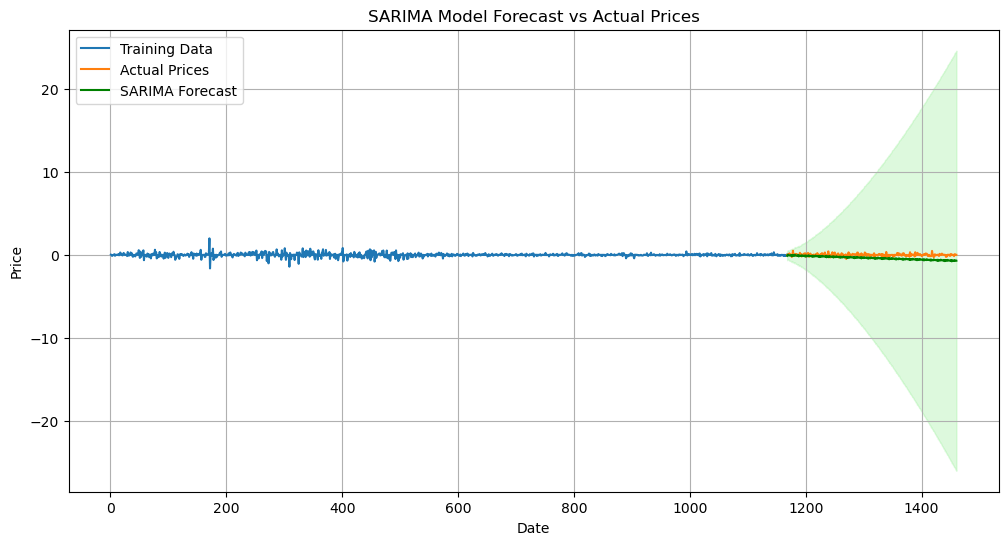

In [25]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Prices')
plt.plot(test.index, sarima_pred, label='SARIMA Forecast', color='green')
plt.fill_between(test.index,
                conf_int.iloc[:,0],
                conf_int.iloc[:,1],
                color='lightgreen', alpha=0.3)
plt.title('SARIMA Model Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

We can conclude that while there is some past volatility in the price changes, there is no predictable, linear pattern that can be reliably projected into the future. A forecast of a flat line at zero for a differenced series can be interpreted as the next change in price is unpredictable and will most likely be zero, and we are very uncertain about the magnitude of the next change

## XGBoost

In [45]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

## Feature Engineering for XGBoost Model

The feature engineering process creates temporal features that help the model capture patterns in the natural gas price data:

1. **DateTime Features**:
   - `dayofweek`: Day of week (0-6)
   - `month`: Month of year (1-12)
   - `year`: Year

2. **Lag Features**:
   - Price lags: 1, 2, 3, and 7-day lagged price values
   - Temperature lags: 1, 2, 3, and 7-day lagged temperature values

These features allow the model to:
- Recognize weekly/monthly seasonality patterns
- Learn from recent price and temperature trends
- Capture autocorrelation in the time series

In [47]:
def create_features(df, target_col='price'):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    
    for lag in [1, 2, 3, 7, 14, 30]:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
        df[f'temp_lag_{lag}'] = df['temperature'].shift(lag)
        df[f'hdd_lag_{lag}'] = df['hdd'].shift(lag)
        df[f'cdd_lag_{lag}'] = df['cdd'].shift(lag)
    
    return df

## Create features

The engineered features are particularly valuable because:
- Natural gas prices often exhibit short-term momentum
- Weather patterns (temperature) significantly impact demand
- Consumption follows weekly and seasonal cycles

In [49]:
df = df.set_index('date')
df_features = create_features(df)

df_features = df_features.dropna()

## Splitting into features and target

In [51]:
X = df_features.drop(['price'], axis=1)
y = df_features['price']

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

## XGBoost Configuration

**Parameters**:
- Objective: Squared error regression
- 1000 trees max (early stopping at 50 rounds no improvement)
- Learning rate: 0.01
- Random seed: 42

**Training**:
- Monitors both train/test sets
- Stops automatically if no improvement
- Progress shown every 100 rounds

In [53]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=1000,
                            learning_rate=0.01,
                            early_stopping_rounds=50,
                            random_state=42)

xgb_model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_test, y_test)],
             verbose=100)

[0]	validation_0-rmse:2.06425	validation_1-rmse:0.54699
[100]	validation_0-rmse:0.78225	validation_1-rmse:0.21936
[200]	validation_0-rmse:0.30256	validation_1-rmse:0.17141
[300]	validation_0-rmse:0.12120	validation_1-rmse:0.16483
[351]	validation_0-rmse:0.07799	validation_1-rmse:0.16512


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

## Making Predictions and calculating Evaluation Metrics

In [55]:
xgb_pred = xgb_model.predict(X_test)

xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

print(f"\nXGBoost Model Performance:")
print(f"MSE: {xgb_mse:.4f}")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE: {xgb_mae:.4f}")


XGBoost Model Performance:
MSE: 0.0272
RMSE: 0.1648
MAE: 0.1232


Apperantly, XGBoost model achieves strong performance with an average error of 0.12, outperforming ARIMA/SARIMA methods. Its main limitation may be reduced accuracy during extreme price volatility events.

## Plotting feature importance

<Figure size 1200x800 with 0 Axes>

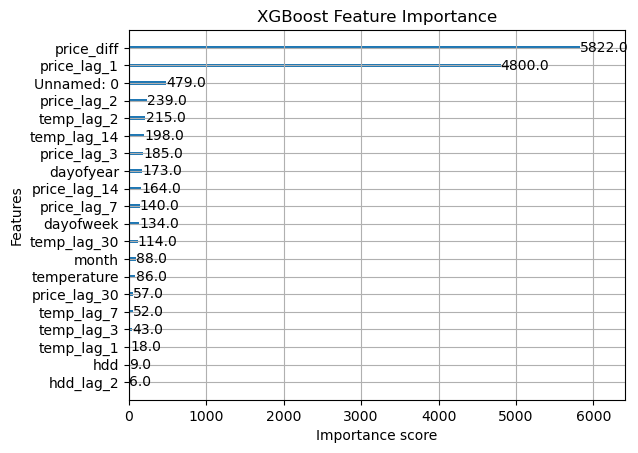

In [57]:
plt.figure(figsize=(12,8))
xgb.plot_importance(xgb_model, max_num_features=20)
plt.title('XGBoost Feature Importance')
plt.show()

We can interpret which features played a key role in our model's prediction to explain its predictive behaviour:
 - Dominant Predictors: The price_diff and price_lag_1 features are by far the most important. This indicates that the most recent price change and the price from the previous period are the best predictors of the next price
 - Other Influences: Other lagged price values and lagged temperature (temp_lag) also play a role, but their importance is significantly lower
 - Time Features: The dayofyear and month features contribute to the model, confirming that seasonal patterns have some influence on the price

## Plotting predictions vs actuals

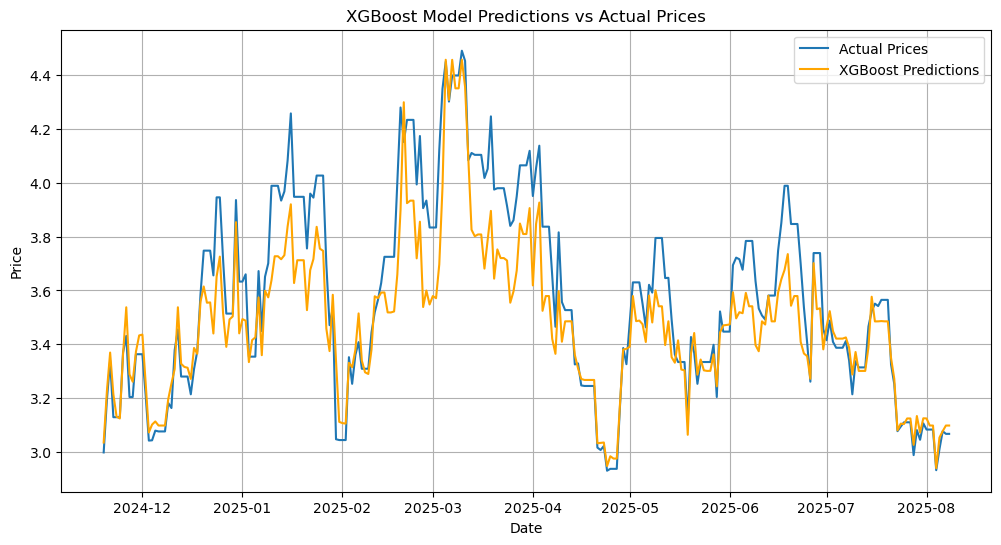

In [59]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual Prices')
plt.plot(y_test.index, xgb_pred, label='XGBoost Predictions', color='orange')
plt.title('XGBoost Model Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Model comparison
Unlike the flat-line forecast from the ARIMA/SARIMA model, the XGBoost captures the volatility and sharp changes in price. with the help of engineered features (lagged prices and seasonal factors) to predict the next value, rather than relying solely on the linear relationships of past values.

While the ARIMA(0,1,0) model correctly identified the series as a random walk and provided a flat-line forecast (which is statistically correct for that model type), the XGBoost model found a way to predict the series's movements by using a more comprehensive set of features